In [12]:
import tensorflow as tf
from tensorflow.keras.layers import Rescaling

# Preprocessing

In [13]:
# Paths and constants
data_dir = "Data/images"
batch_size = 32
img_height = 224
img_width = 224
val_split = 0.2
seed = 50

In [14]:
# Load training data: infer labels from folder names
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=val_split,
    subset="training",
    seed=seed,
    image_size=(img_height, img_width),
    batch_size=batch_size,
    label_mode="categorical"
)

# Load validation data
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=val_split,
    subset="validation",
    seed=seed,
    image_size=(img_height, img_width),
    batch_size=batch_size,
    label_mode="categorical"
)

Found 2647 files belonging to 12 classes.
Using 2118 files for training.
Found 2647 files belonging to 12 classes.
Using 529 files for validation.


In [15]:
# Normalise pixel values to [0,1]
normalisation_layer = Rescaling(1./255)
train_ds = train_ds.map(lambda x, y: (normalisation_layer(x), y))
val_ds = val_ds.map(lambda x, y: (normalisation_layer(x), y))

In [16]:
# Data augmentation
from tensorflow.keras import layers

data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"), # Randomly flip images horizontally
    layers.RandomRotation(0.05), # Randomly rotate images by 5% of a full circle
    layers.RandomZoom(0.1), # Randomly zoom image by 10%
    layers.RandomContrast(0.1) # Randomly adjust image contrast by 10%
])

# ResNet50 Model

In [17]:
# Load pretrained ResNet50 model
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input

base_model = ResNet50(
    include_top=False, # Remove the fully-connected layers used for ImageNet classification
    weights="imagenet", # Load pretrained weights from ImageNet
    input_shape=(img_height, img_width, 3),
    pooling="avg" # Global average pooling layer to convert 3D tensor to 1D
)
base_model.trainable = False # Freeze the base model for now

In [18]:
# Build the model
from tensorflow.keras import Model

num_classes = 12 # 12 neurons, one per country class

inputs = tf.keras.Input(shape=(img_height, img_width, 3)) # Input layer
x = data_augmentation(inputs) # Apply data augmentation
x = preprocess_input(x) # Preprocess input for ResNet50
x = base_model(x, training=False) # Pass the input through the base model
x = layers.Dense(128)(x) # Add a fully connected layer with 128 neurons
x = layers.BatchNormalization()(x) # Add batch normalisation layer
x = layers.Activation("relu")(x) # Add ReLU activation function
x = layers.Dropout(0.3)(x) # Add dropout layer with 30% rate
outputs = layers.Dense(num_classes, activation="softmax")(x) # Add output layer with softmax activation

model = Model(inputs, outputs)

# Compile the model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), # Adam optimiser with learning rate of 0.001 for faster convergence
    loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.1), # Categorical cross-entropy loss with label smoothing of 0.1 to prevent overfitting
    metrics=["accuracy"]
)

In [19]:
# Add callbacks to prevent overfitting, adjust learning rate and save the best model
callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True), # Stop training after 5 epochs with no improvement in validation loss
    tf.keras.callbacks.ReduceLROnPlateau(patience=3, factor=0.2), # Reduce learning rate by 20% after 3 epochs with no improvement in validation loss
    tf.keras.callbacks.ModelCheckpoint("best_model.h5", save_best_only=True) # Save the best model based on validation loss
]

In [20]:
# Train the model
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=20,
    callbacks=callbacks
)

Epoch 1/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.1711 - loss: 2.4798

67/67 ━━━━━━━━━━━━━━━━━━━━ 421s 6s/step - accuracy: 0.1720 - loss: 2.4780 - val_accuracy: 0.1380 - val_loss: 2.4693 - learning_rate: 0.0010
Epoch 2/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.2982 - loss: 2.1896

67/67 ━━━━━━━━━━━━━━━━━━━━ 400s 6s/step - accuracy: 0.2983 - loss: 2.1894 - val_accuracy: 0.1172 - val_loss: 2.4518 - learning_rate: 0.0010
Epoch 3/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.3566 - loss: 2.0765

67/67 ━━━━━━━━━━━━━━━━━━━━ 433s 6s/step - accuracy: 0.3565 - loss: 2.0762 - val_accuracy: 0.1040 - val_loss: 2.3862 - learning_rate: 0.0010
Epoch 4/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 423s 6s/step - accuracy: 0.3407 - loss: 2.0527 - val_accuracy: 0.0794 - val_loss: 2.8376 - learning_rate: 0.0010
Epoch 5/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 412s 6s/step - accuracy: 0.3657 - loss: 2.0031 - val_accuracy: 0.1078 - val_loss: 3.1023 - learning_rate: 0.0010
Epoch 6/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 445s 6s/step - accuracy: 0.3841 - loss: 1.9495 - val_accuracy: 0.1796 - val_loss: 2.8488 - learning_rate: 0.0010
Epoch 7/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 411s 6s/step - accuracy: 0.3986 - loss: 1.9162 - val_accuracy: 0.1834 - val_loss: 2.5464 - learning_rate: 2.0000e-04
Epoch 8/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.4042 - loss: 1.9183

67/67 ━━━━━━━━━━━━━━━━━━━━ 418s 6s/step - accuracy: 0.4044 - loss: 1.9179 - val_accuracy: 0.1947 - val_loss: 2.3557 - learning_rate: 2.0000e-04
Epoch 9/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.4174 - loss: 1.8936

67/67 ━━━━━━━━━━━━━━━━━━━━ 415s 6s/step - accuracy: 0.4175 - loss: 1.8934 - val_accuracy: 0.3327 - val_loss: 2.0893 - learning_rate: 2.0000e-04
Epoch 10/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 418s 6s/step - accuracy: 0.4329 - loss: 1.8626 - val_accuracy: 0.3214 - val_loss: 2.2461 - learning_rate: 2.0000e-04
Epoch 11/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 423s 6s/step - accuracy: 0.4193 - loss: 1.8593 - val_accuracy: 0.3308 - val_loss: 2.1987 - learning_rate: 2.0000e-04
Epoch 12/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 414s 6s/step - accuracy: 0.4241 - loss: 1.8706 - val_accuracy: 0.3251 - val_loss: 2.1252 - learning_rate: 2.0000e-04
Epoch 13/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.4369 - loss: 1.8458

67/67 ━━━━━━━━━━━━━━━━━━━━ 410s 6s/step - accuracy: 0.4369 - loss: 1.8455 - val_accuracy: 0.3611 - val_loss: 1.9283 - learning_rate: 4.0000e-05
Epoch 14/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.4464 - loss: 1.8218

67/67 ━━━━━━━━━━━━━━━━━━━━ 397s 6s/step - accuracy: 0.4462 - loss: 1.8219 - val_accuracy: 0.4102 - val_loss: 1.8766 - learning_rate: 4.0000e-05
Epoch 15/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.4502 - loss: 1.8219

67/67 ━━━━━━━━━━━━━━━━━━━━ 408s 6s/step - accuracy: 0.4502 - loss: 1.8219 - val_accuracy: 0.4197 - val_loss: 1.8706 - learning_rate: 4.0000e-05
Epoch 16/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 406s 6s/step - accuracy: 0.4273 - loss: 1.8616 - val_accuracy: 0.4178 - val_loss: 1.8788 - learning_rate: 4.0000e-05
Epoch 17/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.4469 - loss: 1.8108

67/67 ━━━━━━━━━━━━━━━━━━━━ 406s 6s/step - accuracy: 0.4470 - loss: 1.8107 - val_accuracy: 0.4178 - val_loss: 1.8683 - learning_rate: 4.0000e-05
Epoch 18/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 410s 6s/step - accuracy: 0.4713 - loss: 1.8226 - val_accuracy: 0.4083 - val_loss: 1.9119 - learning_rate: 4.0000e-05
Epoch 19/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 406s 6s/step - accuracy: 0.4614 - loss: 1.8114 - val_accuracy: 0.3932 - val_loss: 1.9527 - learning_rate: 4.0000e-05
Epoch 20/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 404s 6s/step - accuracy: 0.4327 - loss: 1.8631 - val_accuracy: 0.3875 - val_loss: 1.9424 - learning_rate: 4.0000e-05


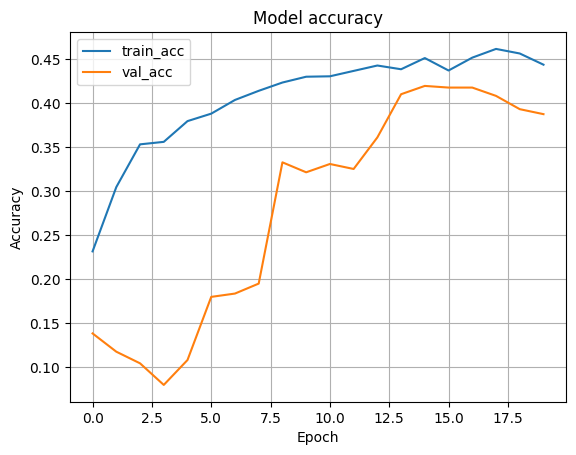

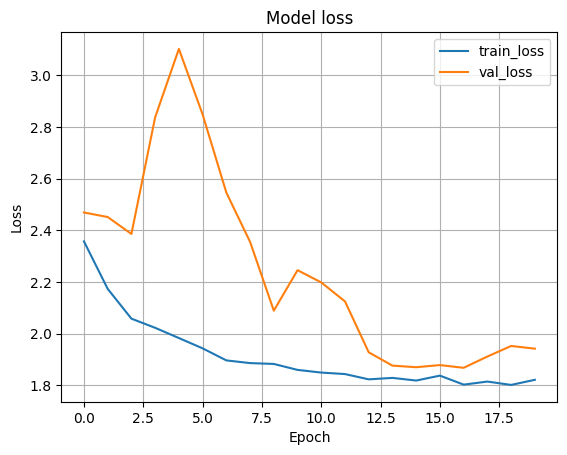

In [ ]:
# Plot model accuracy and model loss
import matplotlib.pyplot as plt

plt.plot(history.history["accuracy"], label="train_acc")
plt.plot(history.history["val_accuracy"], label="val_acc")
plt.title("Model accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid()
plt.show()

plt.plot(history.history["loss"], label="train_loss")
plt.plot(history.history["val_loss"], label="val_loss")
plt.title("Model loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid()
plt.show()

# Fine-tuning

In [26]:
# Unfreeze layers in the base model for fine-tuning
base_model.trainable = True

fine_tune_at = 100  # Freeze all but the top N layers
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

# Compile the model for fine-tuning
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5), # Lower learning rate for fine-tuning
    loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.1), # Categorical cross-entropy loss with label smoothing
    metrics=["accuracy"]
)

# Train the model with fine-tuning
fine_tune_epochs = 10
initial_epochs = len(history.epoch)

history_fine = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=initial_epochs + fine_tune_epochs,
    initial_epoch = initial_epochs,
    callbacks=callbacks
)

Epoch 21/30
67/67 ━━━━━━━━━━━━━━━━━━━━ 599s 9s/step - accuracy: 0.3023 - loss: 2.1641 - val_accuracy: 0.1550 - val_loss: 2.9051 - learning_rate: 1.0000e-05
Epoch 22/30
67/67 ━━━━━━━━━━━━━━━━━━━━ 545s 8s/step - accuracy: 0.3999 - loss: 1.9490 - val_accuracy: 0.2098 - val_loss: 2.5383 - learning_rate: 1.0000e-05
Epoch 23/30
67/67 ━━━━━━━━━━━━━━━━━━━━ 542s 8s/step - accuracy: 0.4282 - loss: 1.8909 - val_accuracy: 0.2741 - val_loss: 2.3081 - learning_rate: 1.0000e-05
Epoch 24/30
67/67 ━━━━━━━━━━━━━━━━━━━━ 520s 8s/step - accuracy: 0.4341 - loss: 1.8445 - val_accuracy: 0.3573 - val_loss: 1.9897 - learning_rate: 1.0000e-05
Epoch 25/30
67/67 ━━━━━━━━━━━━━━━━━━━━ 3911s 59s/step - accuracy: 0.4495 - loss: 1.7849 - val_accuracy: 0.3781 - val_loss: 1.9494 - learning_rate: 1.0000e-05
Epoch 26/30
67/67 ━━━━━━━━━━━━━━━━━━━━ 538s 8s/step - accuracy: 0.4706 - loss: 1.7610 - val_accuracy: 0.4064 - val_loss: 1.8693 - learning_rate: 1.0000e-05
Epoch 27/30
67/67 ━━━━━━━━━━━━━━━━━━━━ 3241s 49s/step - accura

67/67 ━━━━━━━━━━━━━━━━━━━━ 542s 8s/step - accuracy: 0.5324 - loss: 1.6036 - val_accuracy: 0.4575 - val_loss: 1.8034 - learning_rate: 2.0000e-06


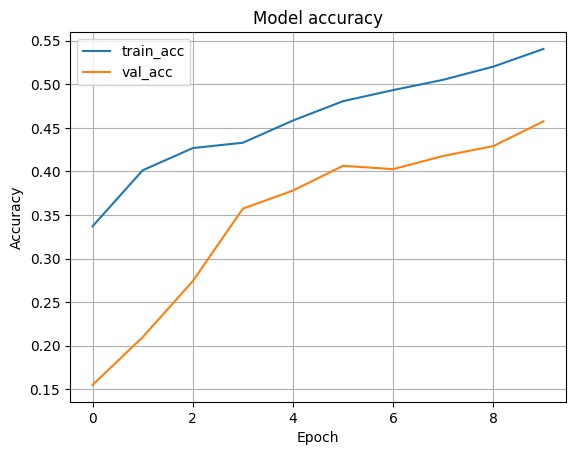

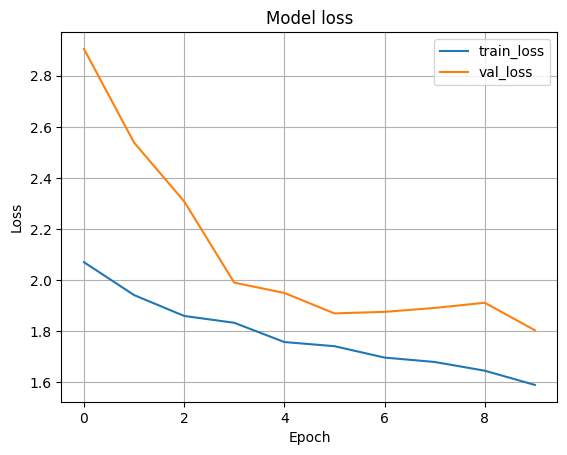

In [ ]:
# Plot model accuracy and model loss
plt.plot(history_fine.history["accuracy"], label="train_acc")
plt.plot(history_fine.history["val_accuracy"], label="val_acc")
plt.title("Model accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid()
plt.show()

plt.plot(history_fine.history["loss"], label="train_loss")
plt.plot(history_fine.history["val_loss"], label="val_loss")
plt.title("Model loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid()
plt.show()

# Interpretability

c:\Users\fabri\AppData\Local\Programs\Python\Python312\Lib\site-packages\PIL\Image.py:3402: DecompressionBombWarning: Image size (134217728 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


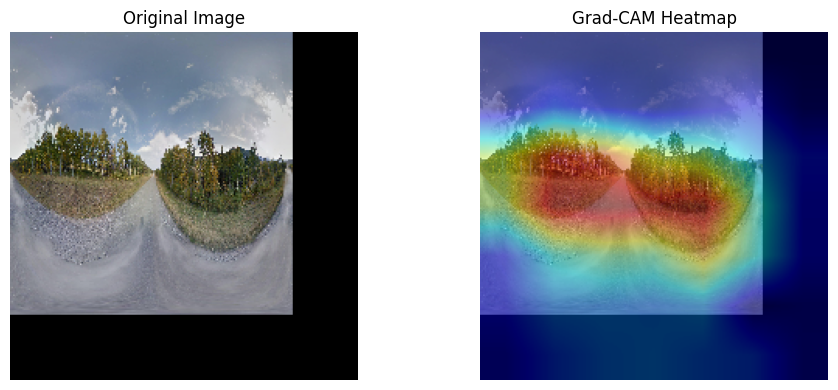

In [45]:
# Gradient-weighted Class Activation Mapping (Grad-CAM)
import cv2

# Define the Grad-CAM function
def make_gradcam_heatmap(img_array, full_model, pred_index=None):
    base_model = full_model.get_layer("resnet50")
    last_conv_layer = base_model.get_layer("conv5_block3_out")

    grad_model = tf.keras.models.Model(
        inputs=base_model.input,
        outputs=[last_conv_layer.output, base_model.output]
    )

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(predictions[0]).numpy()
        class_channel = predictions[:, pred_index]

    grads = tape.gradient(class_channel, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    conv_outputs = conv_outputs[0]
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

# Superimpose the heatmap on the original image
def display_gradcam(img_path, model, alpha=0.4):
    # Load and preprocess the image
    img = tf.keras.preprocessing.image.load_img(img_path, target_size=(224, 224))
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = tf.keras.applications.resnet50.preprocess_input(img_array)

    # Generate heatmap
    heatmap = make_gradcam_heatmap(img_array, model)

    # Load original image for overlay
    img = cv2.imread(img_path)
    img = cv2.resize(img, (224, 224))
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    heatmap_color = cv2.applyColorMap(np.uint8(255 * heatmap), cv2.COLORMAP_JET)
    superimposed_img = cv2.addWeighted(img, 1 - alpha, heatmap_color, alpha, 0)

    # Plot
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.title("Original Image")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(cv2.cvtColor(superimposed_img, cv2.COLOR_BGR2RGB))
    plt.title("Grad-CAM Heatmap")
    plt.axis("off")
    plt.tight_layout()
    plt.show()

# Display Grad-CAM heatmap for a sample image
img_path = "Data/images/canada/1741638729_50.232387_-114.3907119.jpg"  # Pick a Street View image
display_gradcam(img_path, model)

# FIX NEXT SECTION

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


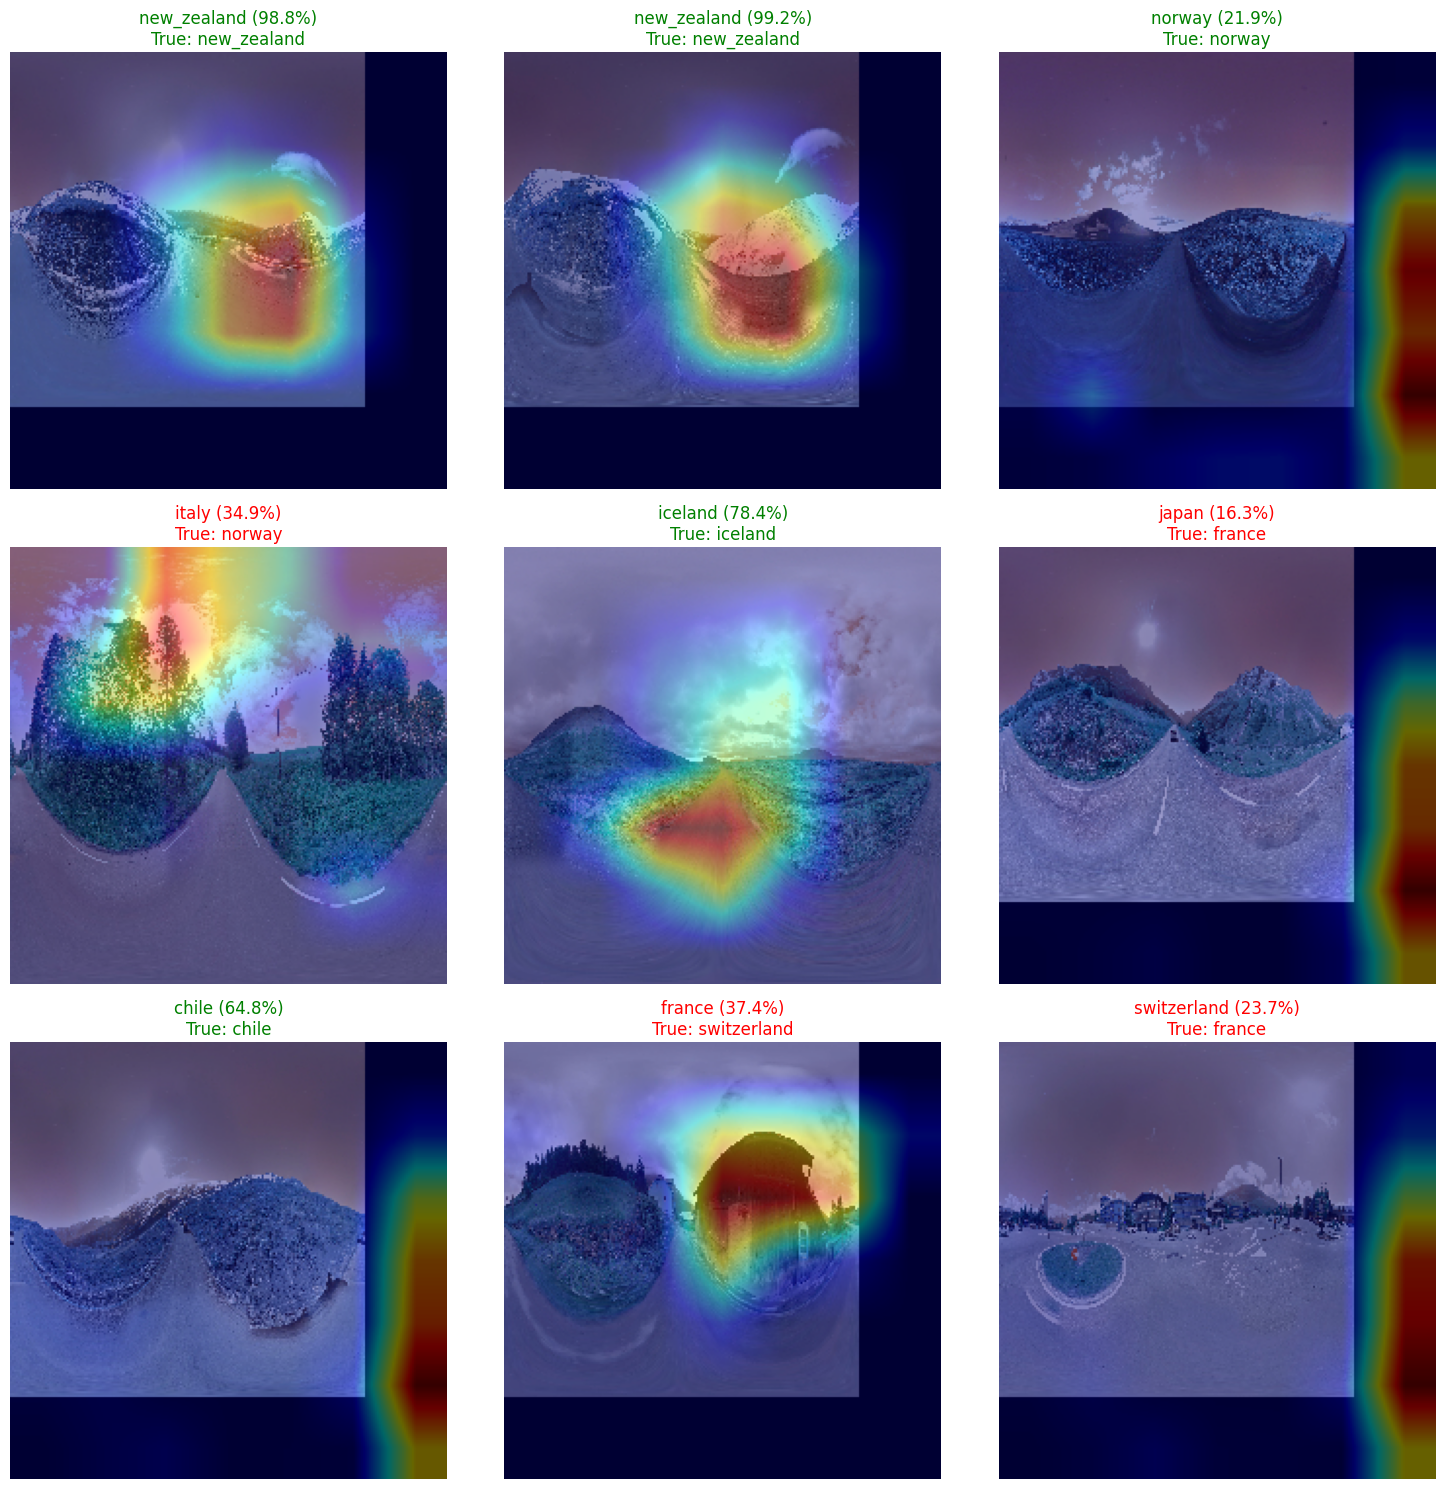

In [59]:
# Grad-CAM heatmap on a batch
def display_gradcam_batch(dataset, model, class_names, num_images=9, alpha=0.4):
    import math
    plt.figure(figsize=(15, 5 * math.ceil(num_images / 3)))
    count = 0

    for images, labels in dataset:
        preds = model.predict(images)
        pred_labels = np.argmax(preds, axis=1)
        true_labels = np.argmax(labels.numpy(), axis=1)
        confidences = np.max(preds, axis=1)

        for i in range(images.shape[0]):
            if count >= num_images:
                break

            img = images[i].numpy()
            img_array = tf.keras.applications.resnet50.preprocess_input(np.expand_dims(img.copy(), axis=0))
            heatmap = make_gradcam_heatmap(img_array, model)

            # Resize and overlay heatmap on original image
            original = (img * 255).astype("uint8") if np.max(img) <= 1 else img.astype("uint8")
            heatmap_resized = cv2.resize(heatmap, (original.shape[1], original.shape[0]))
            heatmap_color = cv2.applyColorMap(np.uint8(255 * heatmap_resized), cv2.COLORMAP_JET)
            superimposed_img = cv2.addWeighted(original, 1 - alpha, heatmap_color, alpha, 0)

            # Plot image
            ax = plt.subplot(math.ceil(num_images / 3), 3, count + 1)
            plt.imshow(cv2.cvtColor(superimposed_img, cv2.COLOR_BGR2RGB))
            pred = class_names[pred_labels[i]]
            true = class_names[true_labels[i]]
            conf = confidences[i] * 100
            title_color = "green" if pred == true else "red"
            ax.set_title(f"{pred} ({conf:.1f}%)\nTrue: {true}", color=title_color)
            ax.axis("off")

            count += 1

        if count >= num_images:
            break

    plt.tight_layout()
    plt.show()

display_gradcam_batch(val_ds, model, class_names, num_images=9)

In [56]:
# Prediction visualiser
def deprocess_resnet(img_tensor):
    """Undo ResNet50 preprocessing (BGR shift, normalization)"""
    x = img_tensor.numpy().copy()
    x[..., 0] += 103.939  # B
    x[..., 1] += 116.779  # G
    x[..., 2] += 123.68   # R
    x = x[..., ::-1]      # BGR to RGB
    x = np.clip(x, 0, 255).astype("uint8")
    return x

def visualize_predictions(dataset, model, class_names, num_images=16):
    plt.figure(figsize=(15, 10))
    count = 0

    for images, labels in dataset:
        preds = model.predict(images)
        pred_labels = np.argmax(preds, axis=1)
        true_labels = np.argmax(labels.numpy(), axis=1)
        confidences = np.max(preds, axis=1)

        for i in range(images.shape[0]):
            if count >= num_images:
                break

            ax = plt.subplot(int(np.sqrt(num_images)), int(np.sqrt(num_images)), count + 1)
            plt.imshow(images[i].numpy().astype("uint8"))
            
            pred_class = class_names[pred_labels[i]]
            true_class = class_names[true_labels[i]]
            conf = confidences[i] * 100

            correct = pred_class == true_class
            title_color = "green" if correct else "red"
            ax.set_title(f"{pred_class} ({conf:.1f}%)\nTrue: {true_class}", color=title_color)
            ax.axis("off")
            count += 1

        if count >= num_images:
            break

    # Undo float32 [0, 1] scaling, then convert to uint8
img = images[i].numpy()

if np.max(img) <= 1.0:  # if images are [0, 1]
    img = (img * 255).astype("uint8")
else:
    img = img.astype("uint8")

plt.imshow(img)

class_names = [
    'argentina', 'austria', 'canada', 'chile', 'france', 'iceland',
    'italy', 'japan', 'new_zealand', 'norway', 'peru', 'switzerland'
]
visualize_predictions(val_ds, model, class_names=class_names, num_images=16)

NameError: name 'images' is not defined